In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
# General parameters for the script

# Decide whether we're loading a subset or the full set
dataset_size = 'partial'
# dataset_size = 'full'

if dataset_size == 'full':
    file_name = 'full_data.csv'
    file_suffix = '_full'
elif dataset_size == 'partial':
    file_name = 'data.csv'
    file_suffix = ''

In [3]:
# Load data
with open('../../data/processed/dtypes.json') as in_file:
    non_date_dtypes = json.load(in_file)

with open('../../data/processed/date_types.json') as in_file:
    date_dtypes = json.load(in_file)

date_cols = list(date_dtypes)

# Read data, specifically parsing date columns as dates and only picking the features + target
data = pd.read_csv(f'../../data/processed/{file_name}', dtype=non_date_dtypes, parse_dates=date_cols)

In [4]:
data.columns

Index(['Random_ID', 'DaysSinceLastRegistration', 'DaysSinceFirstRegistration',
       'PastRegistrations', 'DaysEligible', 'PercentOfTargetPeriodEligible',
       'LastDonationLocation_Center', 'LastDonationType_Platelets',
       'PastCenterRegistrations', 'PastMobileRegistrations',
       'CenterRegistrationProportion', 'PastPlateletRegistrations',
       'ModalDonationLocation_Center', 'TargetRegistrations',
       'DonationsPerDay', 'CutoffDate', 'RegisteredInTargetPeriod'],
      dtype='object')

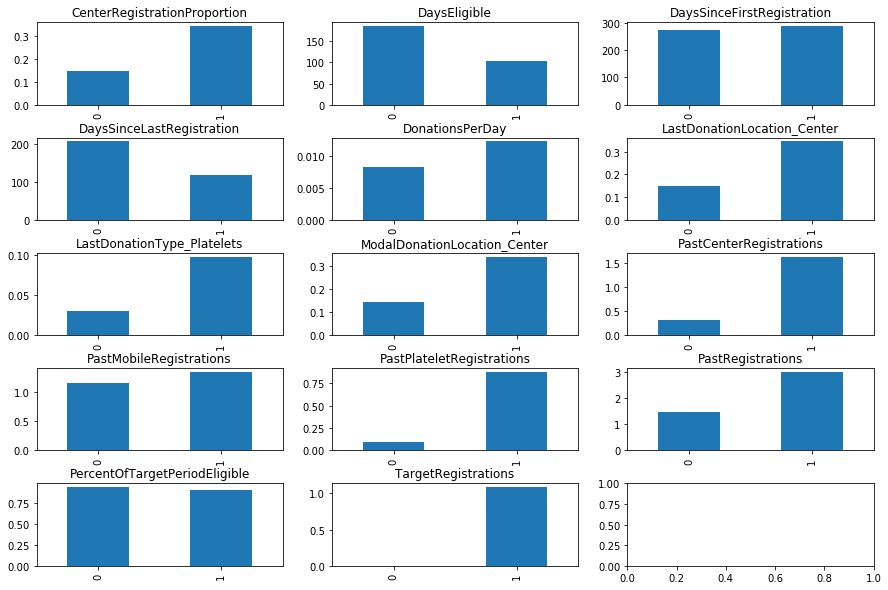

In [5]:
import matplotlib.pyplot as plt

# Compare features between the two classes
feature_means = data.drop('Random_ID', axis=1).groupby('RegisteredInTargetPeriod', as_index=False).mean().melt(id_vars=['RegisteredInTargetPeriod']).set_index('variable').pivot(columns='RegisteredInTargetPeriod')

feature_means.columns = feature_means.columns.droplevel(0)

fig, axes = plt.subplots(ncols=3, nrows=int(np.ceil(feature_means.shape[0] / 3)))  # 3 cols and as many rows as it takes
fig.set_size_inches(15, 10)
plt.subplots_adjust(hspace=0.4)

current_row = 0
current_col = 0
for i, row in feature_means.iterrows():    
    row.plot.bar(ax=axes[current_row, current_col], title=row.name).set_xlabel(None)
    
    if current_col == 2:
        current_col = 0
        current_row += 1
    else:
        current_col += 1

In [6]:
# Select features
target_name = 'RegisteredInTargetPeriod'  # Target variable
features = [
    'DaysSinceLastRegistration', 'DaysSinceFirstRegistration',
    'PastRegistrations', 'DaysEligible', 'LastDonationLocation_Center',
    'LastDonationType_Platelets', 'CenterRegistrationProportion', 'DonationsPerDay',
    'PastPlateletRegistrations'
]

In [7]:
# Take final cutoff date as a holdout set for demo purposes
holdout_cutoff = data['CutoffDate'].unique()[-1]
holdout = data[data['CutoffDate'] == holdout_cutoff][['Random_ID'] + features + [target_name]]
X_holdout = holdout[features]
y_holdout = holdout[target_name]

# Only keep selected features + ID and save to CSV
X_holdout.to_csv(f'../../data/processed/X_holdout{file_suffix}.csv')
y_holdout.to_csv(f'../../data/processed/y_holdout{file_suffix}.csv')

# Keep all other cutoff date sets for training/testing the model
data = data[data['CutoffDate'] != holdout_cutoff][['Random_ID'] + features + [target_name]]  # Only keep ID and selected features

In [8]:
# Split data
X = data[features]
y = data[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=503)

In [9]:
# Create an over- and undersampling pipeline
oversampler = SMOTE(sampling_strategy=0.2)
undersampler = RandomUnderSampler(sampling_strategy=0.5)
resample_pipeline = Pipeline(steps=[('oversample', oversampler), ('undersample', undersampler)])

In [10]:
y_train.value_counts()  # Original distribution

0    769337
1     86999
Name: RegisteredInTargetPeriod, dtype: int64

In [11]:
X_train, y_train = resample_pipeline.fit_resample(X_train, y_train)  # Over- and undersample

In [12]:
y_train.value_counts()  # New distribution

0    307734
1    153867
Name: RegisteredInTargetPeriod, dtype: int64

In [13]:
# Write training and test datasets to CSV
X_train.to_csv(f'../../data/processed/X_train{file_suffix}.csv')
y_train.to_csv(f'../../data/processed/y_train{file_suffix}.csv')
X_test.to_csv(f'../../data/processed/X_test{file_suffix}.csv')
y_test.to_csv(f'../../data/processed/y_test{file_suffix}.csv')